In [1]:
import sys
sys.path.append("../lib/")
from pathlib import Path

from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
#from sklearn.metrics import f1_score

In [12]:
dataset = "L_540_2022_C_E_R_B"

results_path = Path("../results/") / dataset
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

if "file" in data.columns:
    X = data.drop(columns=["label", "file"])    
else:
    X = data.drop(columns=[""])

wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
#X = pd.get_dummies(df.drop(['label', 'file'], axis=1))
#Map the class names to integer values
#class_map = {'Both': 0, 'Control': 1, 'Etoposide': 2, 'Resveratrol': 3}
#y = df['label'] = df['label'].replace(class_map)
y = np.asarray(data.label)
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define a list of models for each class for OVR
ovr_models = []

# For each class, fit a model
for class_i in np.unique(y_train):
    # Create a binary label for the current class
    y_binary = np.where(y_train == class_i, 1, 0)
    
    # Initialize the model. 's(0)' indicates a spline term for the 0th feature
    gam = LogisticGAM(s(0) + s(1), lam=0.6)
    
    # Fit the model
    gam.fit(X_train, y_binary)
    
    # Save the model
    ovr_models.append(gam)

# Predict on the test set for OVR
ovr_predictions = []
for model in ovr_models:
    ovr_predictions.append(model.predict_proba(X_test))

# Transpose the list of predictions and get the class with the highest probability
ovr_predictions = np.array(ovr_predictions).T
ovr_y_pred = np.argmax(ovr_predictions, axis=1)

# Calculate accuracy for OVR
ovr_accuracy = np.sum(ovr_y_pred == y_test) / len(y_test)
#ovr_f1 = f1_score(y_test, ovr_y_pred, average='macro')


In [15]:
# Define a list of models for each pair of classes for OVO
ovo_models = []
ovo_class_pairs = []

# For each pair of classes, fit a model
for pair in combinations(np.unique(y_train), 2):
    # Select only the data points that belong to the current pair of classes
    indices = np.where((y_train == pair[0]) | (y_train == pair[1]))
    
    X_pair = X_train[indices]
    y_pair = np.where(y_train[indices] == pair[0], 0, 1)
    
    # Initialize the model
    gam = LogisticGAM(s(0) + s(1), lam=0.6)
    
    # Fit the model
    gam.fit(X_pair, y_pair)
    
    # Save the model and the class pair
    ovo_models.append(gam)
    ovo_class_pairs.append(pair)

# Predict on the test set for OVO
ovo_predictions = np.zeros((len(X_test), len(np.unique(y_train))))
for model, pair in zip(ovo_models, ovo_class_pairs):
    pair_predictions = model.predict_proba(X_test)
    ovo_predictions[:, pair[0]] += pair_predictions
    ovo_predictions[:, pair[1]] += 1 - pair_predictions

# Get the class with the highest probability
ovo_y_pred = np.argmax(ovo_predictions, axis=1)

# Calculate accuracy for OVO
ovo_accuracy = np.sum(ovo_y_pred == y_test) / len(y_test)
#ovo_f1 = f1_score(y_test, ovo_y_pred, average='macro')


OVR Accuracy: 32.08%
OVO Accuracy: 17.92%


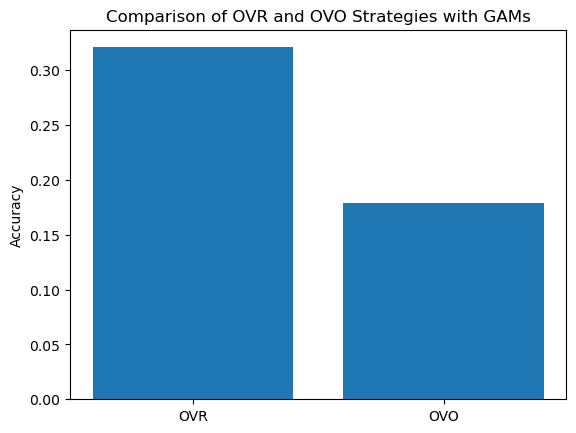

In [16]:
# Compare accuracies
print(f'OVR Accuracy: {ovr_accuracy*100:.2f}%')
#print(f'OVR F1-score: {ovr_f1*100:.2f}%')
print(f'OVO Accuracy: {ovo_accuracy*100:.2f}%')
#print(f'OVO F1-score: {ovo_f1*100:.2f}%')

# Create a bar plot
plt.bar(['OVR', 'OVO'], [ovr_accuracy, ovo_accuracy])
#plt.bar(['OVR_acc','OVR_f1','OVO_acc', 'OVO_f1'], [ovr_accuracy, ovr_f1, ovo_accuracy, ovo_f1])
plt.ylabel('Accuracy')
plt.title('Comparison of OVR and OVO Strategies with GAMs')
plt.show()